<a href="https://colab.research.google.com/github/dhanushnayak/text_emo/blob/main/TextClassificationEmotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libaries
!pip install neattext
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nt 
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,5)
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 114 kB 37.4 MB/s 


In [ ]:
#reading_csv
df = pd.read_csv("https://raw.githubusercontent.com/Jcharis/end2end-nlp-project/main/notebooks/data/emotion_dataset_raw.csv")

In [ ]:
df['clean_text']=df["Text"].apply(nt.remove_stopwords).apply(nt.remove_userhandles).apply(nt.remove_punctuations)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.models import  Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,LSTM ,Dropout, Embedding,Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf

In [ ]:
tok=Tokenizer()
tok.fit_on_texts(df['clean_text'])
seq = tok.texts_to_sequences(df['clean_text'])
y = df['Emotion']
onehot = OneHotEncoder().fit(y.values.reshape(-1,1))
yone1 = onehot.transform(y.values.reshape(-1,1))
yone1=yone1.toarray()
post_pad = pad_sequences(seq, padding='pre',maxlen=256)
voc_size = len(tok.word_index) + 1 # as it was started from 0
x_train1,x_test1,y_train1,y_test1 = train_test_split(post_pad,yone1,test_size=0.3,random_state=42,shuffle=True)

In [ ]:
del model
model = Sequential()
#model.add(Embedding(inp  , op , inp length))
model.add(Embedding(voc_size , 1000 , input_length = 256,))
model.add(Bidirectional(LSTM(100 , return_sequences = True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(100 , activation= 'relu'))
model.add(Dense(50 , activation= 'relu'))
model.add(Dense(8 , activation = 'softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 256, 1000)         35291000  
                                                                 
 bidirectional_10 (Bidirecti  (None, 256, 200)         880800    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 256, 200)          0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 100)              100400    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 100)               10100     
                                                                 
 dense_16 (Dense)            (None, 50)               

In [ ]:
!pip install livelossplot==0.5.0
import livelossplot
#!pip install keras==2.3.1
opt = tf.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,decay_rate=0.98,decay_steps=5)
adam = tf.optimizers.Adam(learning_rate=opt)
sgd = tf.optimizers.SGD(learning_rate=opt)
#model.compile(loss = 'categorical_crossentropy

model.compile(loss = 'categorical_crossentropy' , optimizer = adam ,metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping

#from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from livelossplot.inputs.tf_keras import PlotLossesCallback

checkpoint = ModelCheckpoint("model_weights_dhanush_text_emotion_256v1.h5",monitor="val_accuracy",save_weights_only=True,mode="max",verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='var_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')
early_stop = EarlyStopping(monitor="val_accuracy",patience=10,mode='max',min_delta=0)
callbacks=[PlotLossesCallback(),checkpoint,early_stop]


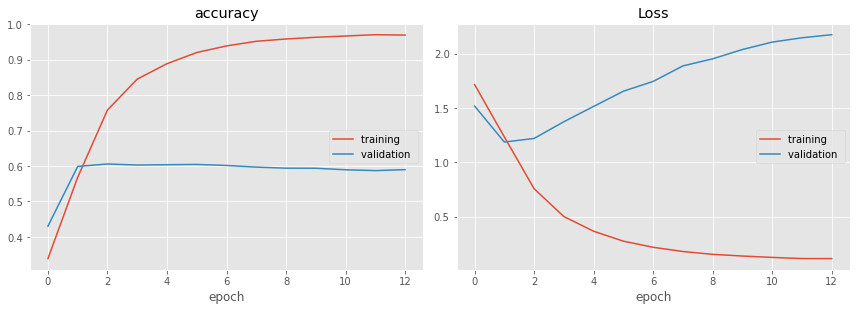

accuracy
	training         	 (min:    0.156, max:    0.971, cur:    0.970)
	validation       	 (min:    0.155, max:    0.606, cur:    0.590)
Loss
	training         	 (min:    0.114, max:    2.014, cur:    0.114)
	validation       	 (min:    1.187, max:    2.176, cur:    2.176)

Epoch 00013: saving model to model_weights_dhanush_text_emotion_256v1.h5
48/48 [==============================] - 43s 894ms/step - loss: 0.1136 - accuracy: 0.9697 - val_loss: 2.1759 - val_accuracy: 0.5899


In [ ]:

history = model.fit(post_pad,yone1,validation_split=0.3,batch_size = 512 , epochs = 500 ,callbacks=callbacks) 


In [ ]:
def predict(text):
  from neattext import TextExtractor
  sentx1 = TextExtractor(text=text)
  text1=sentx1.remove_puncts().remove_stopwords().remove_userhandles().text
  intok=tok.texts_to_sequences([text1])
  seqin = pad_sequences(intok, padding='pre',maxlen=256)
  a= model.predict([seqin])
  return onehot.inverse_transform(a)
text = input()
predict(text)

I am trying to be happy for her


array([['joy']], dtype=object)

In [ ]:
import pickle

# saving
with open('tokenizer_text_emotion.pkl', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model_json = model.to_json()
with open("Keras_model_for_text_emotion.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Keras_model_for_text_emotion_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import joblib
#joblib.dump(onehot, 'onehot_encoder_text_emotion.pkl')

In [ ]:
from keras.models import model_from_json

In [ ]:
json_file = open('Keras_model_for_text_emotion.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("Keras_model_for_text_emotion_weights.h5")
print("Loaded model from disk")


FileNotFoundError: ignored

In [ ]:
token_loaded= joblib.load("tokenizer_text_emotion.pkl")
onehot_loaded = joblib.load("onehot_encoder_text_emotion.pkl")

NameError: ignored

In [ ]:
def predict_load(text):
  from neattext import TextExtractor
  sentx1 = TextExtractor(text=text)
  text1=sentx1.remove_puncts().remove_stopwords().remove_userhandles().text
  intok=token_loaded.texts_to_sequences([text1])
  seqin = pad_sequences(intok, padding='pre',maxlen=256)
  a= loaded_model.predict([seqin])
  return onehot_loaded.inverse_transform(a)

In [ ]:
text = input()
predict_load(text)

snslhsl


NameError: ignored